In [23]:
# importa las librerias necesarias para manejar datos, realizar operaciones numericas y conectar con postgresql
import pandas as pd 
import numpy as np 
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# establece la conexion con la base de datos postgresql usando las credenciales y parametros especificados
conn = psycopg2.connect(
    dbname="reservas_proyecto",
    user = "postgres",
    password = "admin",
    host = "localhost",
    port = "5432")

In [3]:
# crea un cursor para ejecutar consultas en la base de datos
cur = conn.cursor()

In [75]:
# define la consulta SQL para obtener los datos clave, ejecuta la consulta y obtiene los resultados 
query = """
        SELECT 
            r.fecha_reserva, 
            r.precio_noche, 
            h.nombre_hotel, 
            h.competencia, 
            h.estrellas 
        FROM reservas r
        JOIN hoteles h ON r.id_hotel = h.id_hotel;
"""
cur.execute(query)
data = cur.fetchall()
data

[(datetime.date(2025, 2, 21), 161.0, 'ibis Styles Madrid Prado', True, 4.7),
 (datetime.date(2025, 2, 21), 110.0, 'ibis budget Madrid Calle 30', True, 4.4),
 (datetime.date(2025, 2, 9), 119.96, 'Hotel Monte Verde', False, 3.1),
 (datetime.date(2025, 2, 8), 211.53, 'Hotel Brisas del Mar', False, 3.1),
 (datetime.date(2025, 2, 2), 378.37, 'Hotel Camino del Sol', False, 3.1),
 (datetime.date(2025, 2, 8), 85.45, 'Hotel Puerta del Cielo', False, 3.0),
 (datetime.date(2025, 2, 9), 309.8, 'Hotel Encanto Real', False, 3.0),
 (datetime.date(2025, 2, 21),
  172.0,
  'ibis Madrid Centro las Ventas',
  True,
  4.5),
 (datetime.date(2025, 2, 10), 434.88, 'Palacio del Sol', False, 3.0),
 (datetime.date(2025, 2, 21),
  119.0,
  'ibis budget Madrid Centro las Ventas',
  True,
  4.3),
 (datetime.date(2025, 2, 2), 216.57, 'Hotel Jardines del Rey', False, 2.9),
 (datetime.date(2025, 2, 21), 102.0, 'ibis budget Madrid Vallecas', True, 4.3),
 (datetime.date(2025, 2, 21),
  116.0,
  'ibis Madrid Aeropuerto 

In [76]:
# convierte los resultados a un dataframe de pandas 
df = pd.DataFrame(data, columns=["fecha_reserva", "precio_noche", "nombre_hotel", "competencia", "estrellas"])
df.head()

,fecha_reserva,precio_noche,nombre_hotel,competencia,estrellas
0,2025-02-21,161.00,ibis Styles Madrid Prado,True,4.7
1,2025-02-21,110.00,ibis budget Madrid Calle 30,True,4.4
2,2025-02-09,119.96,Hotel Monte Verde,False,3.1
3,2025-02-08,211.53,Hotel Brisas del Mar,False,3.1
4,2025-02-02,378.37,Hotel Camino del Sol,False,3.1


En este análisis se hará una comparación entre los precios de los hoteles de la competencia y de los hoteles propios, así como se realizará un análisis temporal de las fechas de reserva.

In [67]:
# cuenta el numero de hoteles propios y el numero de hoteles de la competencia 
df_propios = df[df["competencia"] == False]
df_competencia = df[df["competencia"] == True]
print(f'Hay {df_propios["nombre_hotel"].nunique()} hoteles propios')
print(f'Hay {df_competencia["nombre_hotel"].nunique()} hoteles de la competencia')

Hay 19 hoteles propios
Hay 10 hoteles de la competencia


In [68]:
# cuenta el numero de reservas en hoteles de competencia vs hoteles propios
df_propios = df[df["competencia"] == False]
df_competencia = df[df["competencia"] == True]
print(f'Se han realizado {df_propios.shape[0]} reservas en los hoteles propios')
print(f'Se han realizado {df_competencia.shape[0]} reservas en los hoteles de la competencia')

Se han realizado 9828 reservas en los hoteles propios
Se han realizado 5172 reservas en los hoteles de la competencia


In [14]:
# primero calcula el precio medio por noche en los hoteles propios y los hoteles de la competencia 
precio_medio = df.groupby(['competencia'])['precio_noche'].mean().reset_index()
precio_medio

,competencia,precio_noche
0,False,275.062793
1,True,112.147912


In [102]:
# ahora calcula el precio medio por noche para cada hotel (tanto propios como de la competencia)
precio_medio_hoteles = df.groupby(['competencia', 'nombre_hotel'])['precio_noche'].mean().reset_index()
precio_medio_hoteles = precio_medio_hoteles.sort_values(by='precio_noche', ascending=False)
precio_medio_hoteles.head()

,competencia,nombre_hotel,precio_noche
9,False,Hotel Maravilla Real,284.402114
3,False,Hotel Costa Azul,284.282951
18,False,Palacio del Sol,282.492137
13,False,Hotel Puerta del Cielo,280.151236
17,False,Hotel Vista Alegre,279.802133


In [103]:
# valoracion media en los hoteles propios y los hoteles de la competencia 
valoracion_media = df.groupby(['competencia'])['estrellas'].mean().reset_index()
valoracion_media

,competencia,estrellas
1,True,4.388399
0,False,3.011518


In [104]:
# valoracion media para cada hotel (tanto propios como de la competencia)
valoracion_media_hoteles = df.groupby(['competencia', 'nombre_hotel'])['estrellas'].mean().reset_index()
valoracion_media_hoteles = valoracion_media_hoteles.sort_values(by='estrellas', ascending=False)
valoracion_media_hoteles.head()

,competencia,nombre_hotel,estrellas
23,True,ibis Styles Madrid Prado,4.7
22,True,ibis Madrid Centro las Ventas,4.5
25,True,ibis budget Madrid Alcorcon Móstoles,4.5
19,True,ibis Madrid Aeropuerto Barajas,4.4
21,True,ibis Madrid Alcorcon Tresaguas,4.4


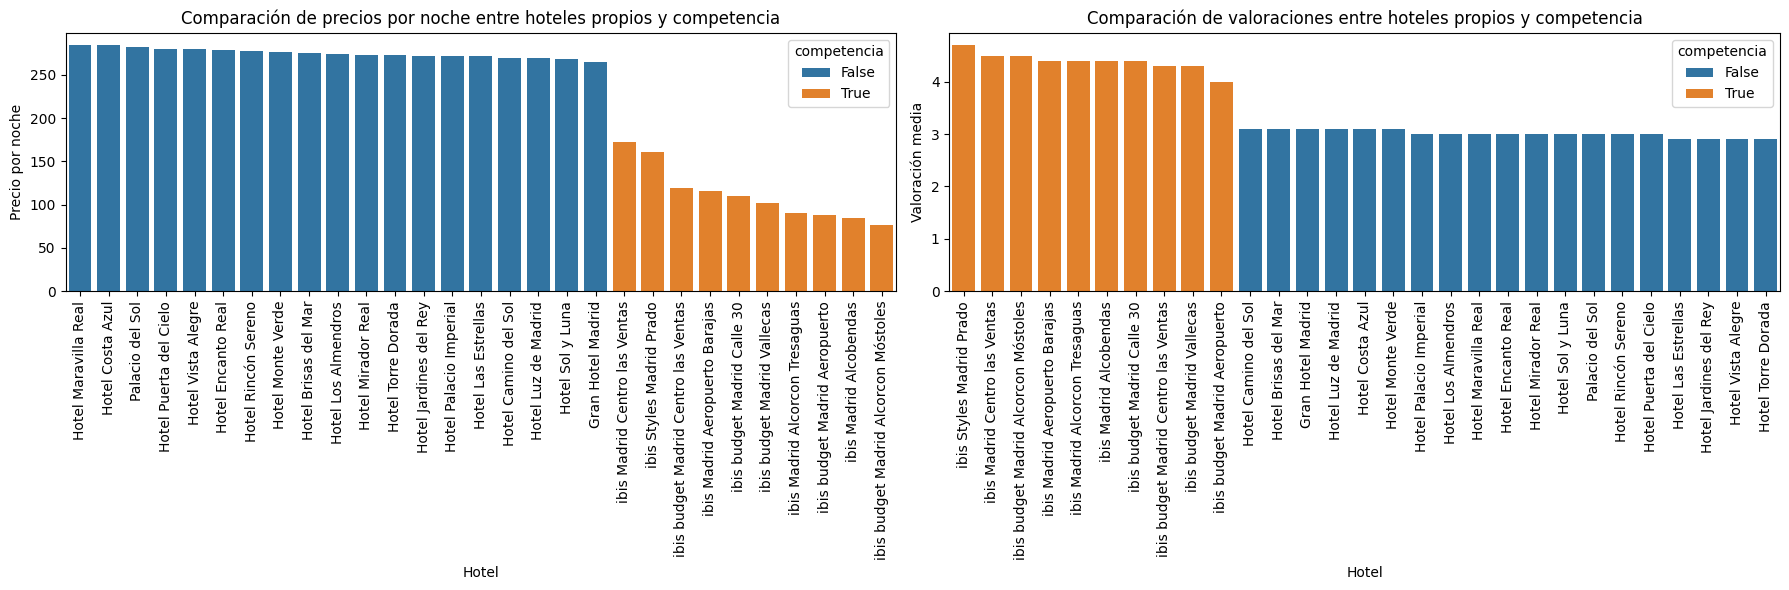

In [105]:
# genera un grafico con dos subplots (uno de comparacion de precios y otro de comparacion de valoraciones)
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1) 
sns.barplot(data=precio_medio_hoteles, 
            x='nombre_hotel', 
            y='precio_noche', 
            hue='competencia')
plt.xticks(rotation=90) 
plt.title('Comparación de precios por noche entre hoteles propios y competencia')
plt.xlabel('Hotel')
plt.ylabel('Precio por noche')

plt.subplot(1, 2, 2)  
sns.barplot(data=valoracion_media_hoteles, 
            x='nombre_hotel', 
            y='estrellas', 
            hue='competencia')
plt.xticks(rotation=90) 
plt.title('Comparación de valoraciones entre hoteles propios y competencia')
plt.xlabel('Hotel')
plt.ylabel('Valoración media')

plt.tight_layout()  
plt.show()

In [51]:
# cuenta el numero de reservas que hay por cada fecha de reserva 
recuento_reservas = df.groupby(['fecha_reserva', 'competencia']).size().reset_index(name='num_reservas')
recuento_reservas

,fecha_reserva,competencia,num_reservas
0,2025-02-01,False,814
1,2025-02-02,False,853
2,2025-02-03,False,833
3,2025-02-04,False,871
4,2025-02-05,False,825
5,2025-02-06,False,872
6,2025-02-07,False,775
7,2025-02-08,False,767
8,2025-02-09,False,820
9,2025-02-10,False,812


In [ ]:
# saca dos dataframes distintos para el recuento de reservas por fecha de reserva de hoteles propios/ competencia
propios = recuento_reservas[recuento_reservas['competencia'] == False]
competencia = recuento_reservas[recuento_reservas['competencia'] == True]

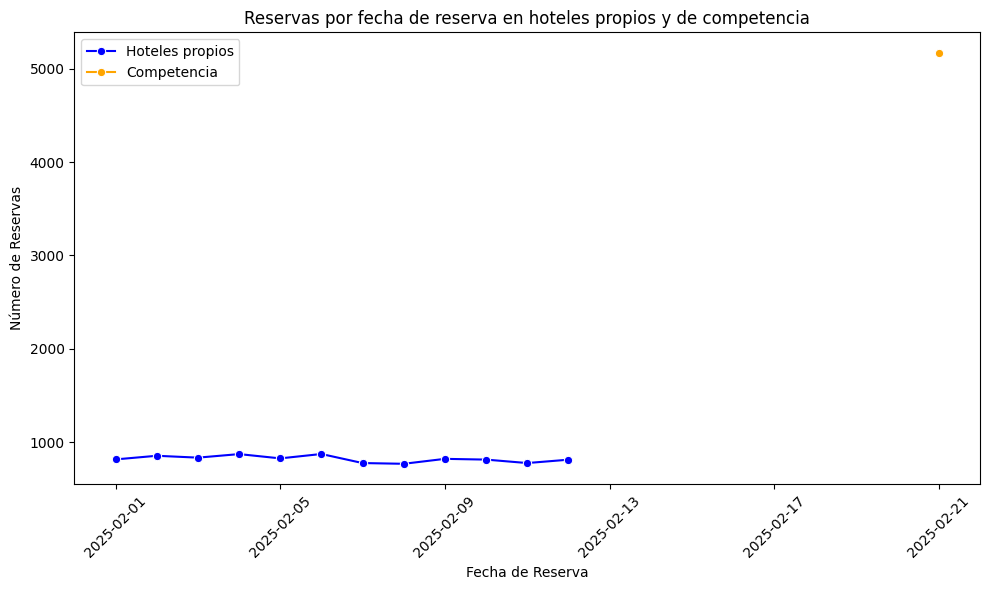

In [101]:
# genera un grafico que muestra el numero de reservas por fecha de reserva para los hoteles propios y de la competencia
plt.figure(figsize=(10, 6))
sns.lineplot(data=propios, 
             x='fecha_reserva', 
             y='num_reservas', 
             label='Hoteles propios', 
             color='blue', 
             marker='o')
sns.lineplot(data=competencia, 
             x='fecha_reserva', 
             y='num_reservas', 
             label='Competencia', 
             color='orange', 
             marker='o')
plt.xlabel('Fecha de Reserva')
plt.ylabel('Número de Reservas')
plt.title('Reservas por fecha de reserva en hoteles propios y de competencia')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

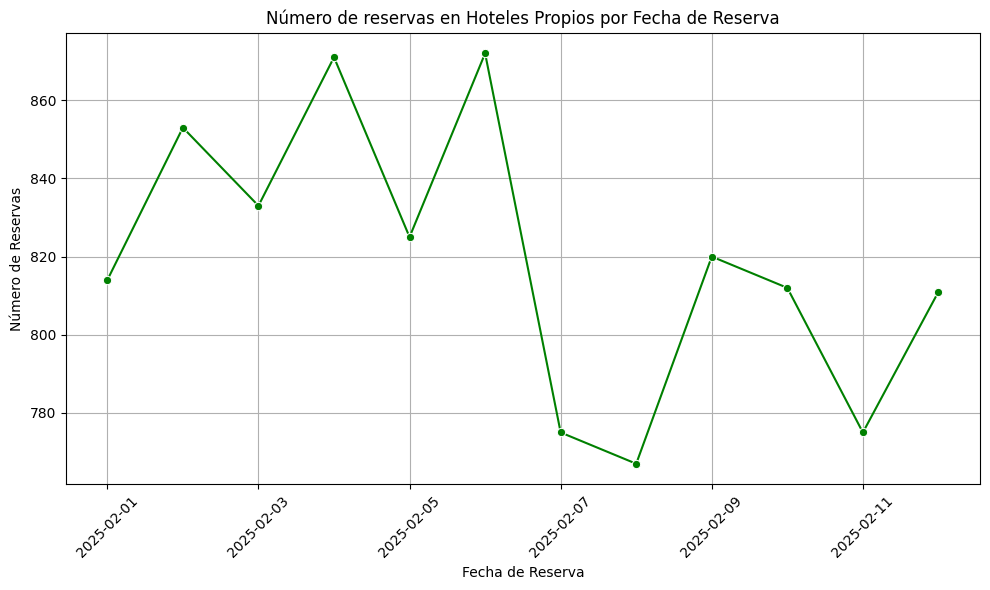

In [99]:
# genera un grafico que muestra el numero de reservas por fecha de reserva (hoteles propios)
plt.figure(figsize=(10, 6))
sns.lineplot(data=propios, 
             x='fecha_reserva', 
             y='num_reservas', 
             color='green', 
             marker='o')
plt.title('Número de reservas en hoteles propios por fecha de reserva')
plt.xlabel('Fecha de Reserva')
plt.ylabel('Número de Reservas')
plt.xticks(rotation=45)  
plt.grid(True)  

plt.tight_layout()
plt.show()

In [108]:
# calcula el numero de reservas por cada hotel diferenciando entre si son de competencia o no
reservas_por_hotel = df.groupby(['competencia', 'nombre_hotel']).size().reset_index(name='num_reservas')
reservas_por_hotel.head()

,competencia,nombre_hotel,num_reservas
0,False,Gran Hotel Madrid,518
1,False,Hotel Brisas del Mar,534
2,False,Hotel Camino del Sol,518
3,False,Hotel Costa Azul,515
4,False,Hotel Encanto Real,511


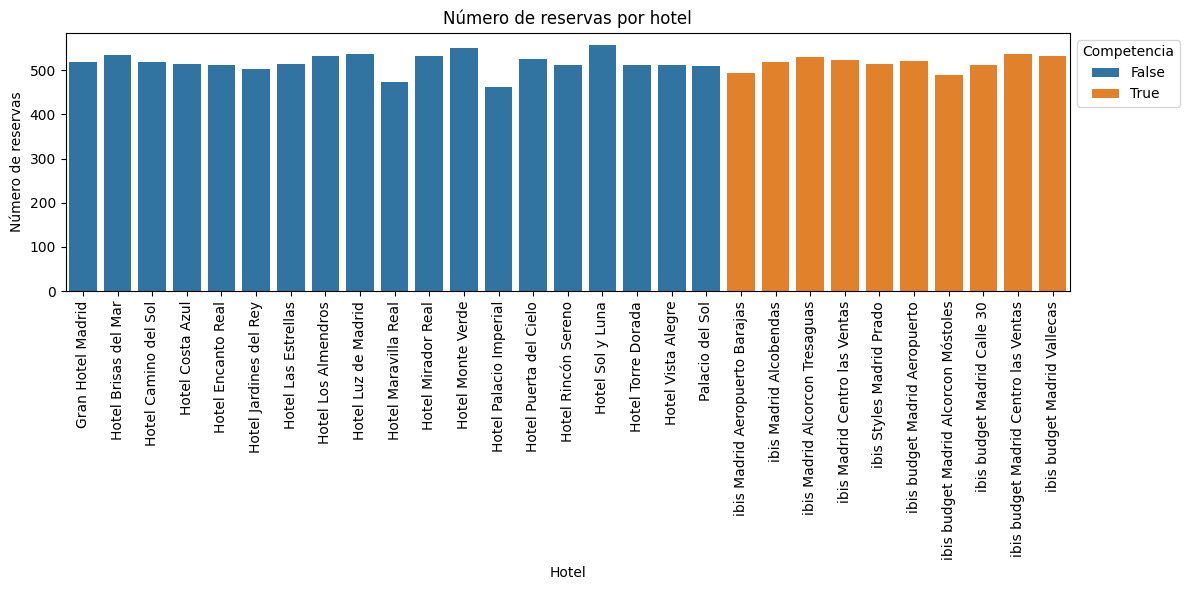

In [109]:
# genera un grafico para mostrar la informacion anterior (numero reservas por hotel)
plt.figure(figsize=(12, 6))
sns.barplot(data=reservas_por_hotel, 
            x='nombre_hotel', 
            y='num_reservas', 
            hue='competencia')
plt.xticks(rotation=90) 
plt.title('Número de reservas por hotel')
plt.xlabel('Hotel')
plt.ylabel('Número de reservas')
plt.legend(title='Competencia', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [110]:
# calcula la recaudacion por cada hotel diferenciando entre si son de competencia o no
recaudacion_por_hotel = df.groupby(['competencia', 'nombre_hotel'])['precio_noche'].sum().reset_index()
recaudacion_por_hotel = recaudacion_por_hotel.sort_values(by='precio_noche', ascending=False)
recaudacion_por_hotel.head()

,competencia,nombre_hotel,precio_noche
11,False,Hotel Monte Verde,152136.80
15,False,Hotel Sol y Luna,149237.76
13,False,Hotel Puerta del Cielo,147359.55
1,False,Hotel Brisas del Mar,146970.65
3,False,Hotel Costa Azul,146405.72


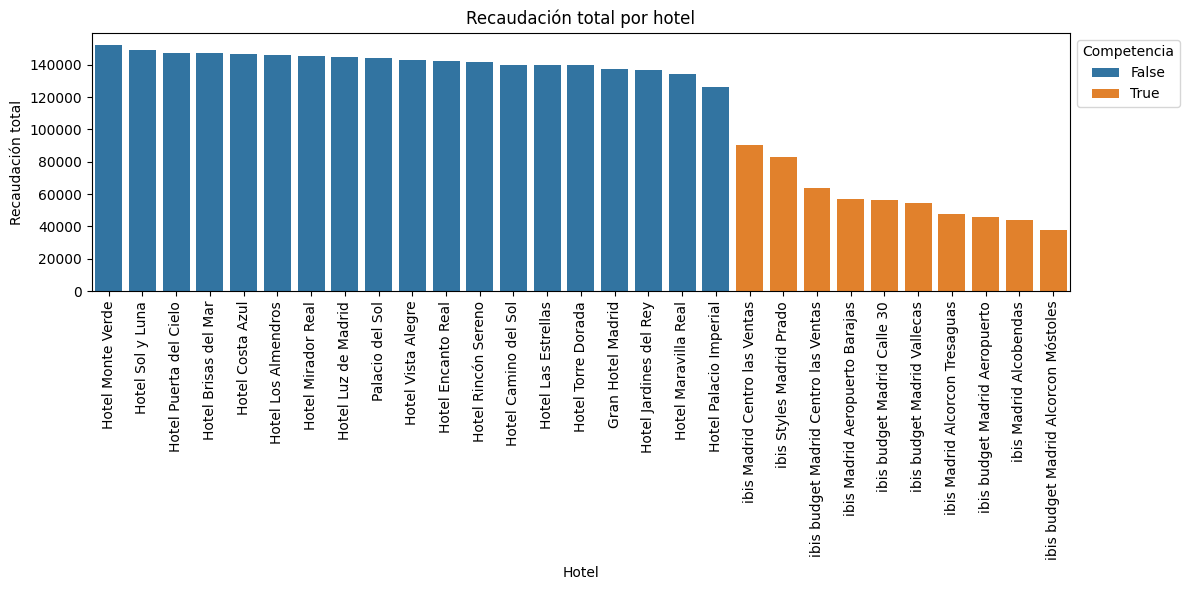

In [111]:
# genera un grafico para mostrar la informacion anterior (recaudacion por hotel)
plt.figure(figsize=(12, 6))
sns.barplot(data=recaudacion_por_hotel, 
            x='nombre_hotel', 
            y='precio_noche', 
            hue='competencia')
plt.xticks(rotation=90) 
plt.title('Recaudación total por hotel')
plt.xlabel('Hotel')
plt.ylabel('Recaudación total')
plt.legend(title='Competencia', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### Resultados del análisis

- Como contexto general sobre los datos de los que disponemos, son datos de reservas realizadas en el mes de febrero de 2025 para una estancia del 1 al 2 de marzo del mismo año. Contamos con 19 hoteles propios y 10 hoteles de la competencia. Además, en los hoteles propios se han realizado un total de 9828 reservas, mientras que en los hoteles de la competencia se han realizado un total de 5172 reservas. 

- En relación con el precio por noche (por persona), de primeras lo que se observa claramente es que los hoteles propios tienen un precio medio por noche bastante más alto que el de los hoteles de la competencia. En el caso de los hoteles propios el precio medio de la noche está en 275 euros y en el caso de los hoteles de la competencia en 112 euros, es decir, la noche en los hoteles propios cuesta más del doble, una diferencia bastante significativa. Además, observo que, en el caso de los hoteles propios, todos tienen un precio medio por noche bastante parecido. El Hotel Maravilla Real sería quien tiene el precio más alto (de 284 euros) pero la diferencia con el Gran Hotel Madrid que es quien tendría el precio por noche más bajo (de 264 euros) es pequeña (20 euros). Sin embargo, entre los precios medios de los hoteles de la competencia sí se observa más diferencia. Dentro de la competencia, el hotel con un precio por noche más elevado es el ibis Madrid Centro las Ventas (172 euros) frente al hotel con el precio por noche más bajo que es el ibis budget Madrid Alcorcon Móstoles (77 euros). Hay una diferencia entre ellos de 100 euros. 

- Lo siguiente que se ha observado es si esta diferencia tan significativa entre los precios por noche de hoteles propios y de la competencia puede venir dada por la calidad de los hoteles, es decir, por la valoración que los clientes hacen de los mismos. Parece que no, los hoteles propios tienen precios por noche elevados pero, sin embargo, todos ellos cuentan con una valoración media de 3 estrellas. Sin embargo, los hoteles de la competencia cuentan con una valoración media de 4,3 estrellas, donde el hotel mejor valorado es el ibis Styles Madrid Prado (con un 4,7) y el que peor sería el ibis budget Madrid Aeropuerto (con un 4), valoración bastante buena y que sigue superando en un 0,9 de estrellas a los hoteles propios con mejor valoración (que tienen un 3,1). En este punto cabe pensar que quizás los hoteles propios deberían valorar su estrategia de precios ya que de forma contraria, sus bajas valoraciones pueden deberse a los elevados precios, y definitivamente, no están resultando muy competitivos. Concretamente el hotel ibis Madrid Centro las Ventas parece el más competitivo, pues dentro de los precios medios de los hoteles de la competencia es el que cuenta con el precio medio por noche más elevado, y su vez, entre todos los hoteles, es el que tiene la mejor valoración. 

- También, podríamos pensar que la diferencia en los precios se puede deber al momento en el que se han realizado las reservas. Es decir, si resulta que en los hoteles de la competencia las reservas se han realizado con más antelación a la fecha de estancia, esto podría explicar los precios más bajos, por ejemplo. Resulta que todas las reservas de los hoteles de la competencia se realizan a finales del mes de febrero (todas el 21 de febrero), mientras que las reservas de los hoteles propios están concentradas en los 12 primeros días del mes, concretamente entre el día 2 y el 6 (se concentran 4254 reservas en estos días, es decir, casi la mitad de todas las que se han hecho). Es definitiva, las reservas se realizan con más antelación en los hoteles propios. Además, todos los hoteles (tanto los de la competencia como los propios) tienen un número de reservas muy parecido, es decir, no es que los hoteles propios tengan un número de reservas más elevado que indicasen mayor demanda y que pudiese explicar el elevado precio por noche, sino que los hoteles de la competencia tienen una demanda muy parecida. De nuevo, no es la demanda tampoco un factor que explique el elevado precio de los hoteles propios. 

- Además, al haber esa variación en los precios tan significativa, pero ser el número de reservas muy parecido entre todos los hoteles, es lógico que los hoteles propios obtienen una recaudación total más elevada en comparación con la de los hoteles de la competencia. A pesar de que la recaudación total termine siendo mayor, habría que continuar investigando si factores distintos como por ejemplo la ubicación dentro de Madrid para cada hotel puede estar influenciando en el precio. Quizás los hoteles propios se encuentran más céntricos que los hoteles de la competencia e influye en los precios. Por ahora, con los datos que disponemos, la diferencia tan significativa entre precios no se explica ni por las valoraciones, ni por la demanda ni por el momento de las reservas, asique quizás los hoteles propios deben revalorar sus estrategias de precios ya que a la larga pueden no resultar demasiado sostenibles. 